# All experiments LTN Notebook

This notebook contains experiments on the MNIST model. It will contain the following experiments:
- changing the number of layers, learning rate etc for basic single_digits_addition and comparing results
- adding different levels of symbolic knowledge to the single_digits_addition
- multiple_digits_addition with more symbolic knowledge

In [1]:
import tensorflow as tf
import ltn
import baselines, data
import commons_updated as commons
import matplotlib.pyplot as plt

## Single Digit Addition

## Data

Dataset of images for the digits X and Y, and their label Z s.t. X+Y=Z.

Result label is 1


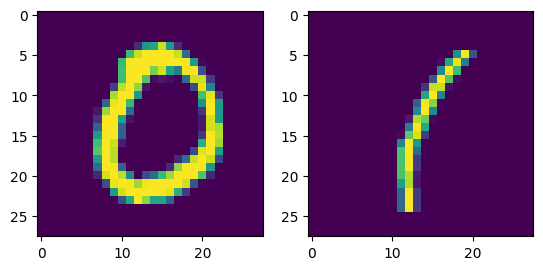

In [2]:
ds_train, ds_test = data.get_mnist_op_dataset(
        count_train=3000,
        count_test=1000,
        buffer_size=3000,
        batch_size=16,
        n_operands=2,
        op=lambda args: args[0]+args[1])

# Visualize one example
x, y, z = next(ds_train.as_numpy_iterator())
plt.subplot(121)
plt.imshow(x[0][:,:,0])
plt.subplot(122)
plt.imshow(y[0][:,:,0])
print("Result label is %i" % z[0])

## Model Definition

In [3]:
class SoftmaxDigitModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def call(self, x):
        logits = self.base_model(x)
        return tf.nn.softmax(logits)

def create_Digit_model(layers_sizes=(84,), batch_size=16):
    logits_model = baselines.SingleDigit(hidden_dense_sizes=layers_sizes, inputs_as_a_list=True)
    softmax_model = SoftmaxDigitModel(logits_model)
    Digit = ltn.Predicate.Lambda(lambda inputs: tf.gather(
    softmax_model([inputs[0]]),
    indices=tf.cast(inputs[1], tf.int32), 
    axis=1,
    batch_dims=1
))
    return Digit, logits_model



In [4]:


# Digit, logits_model = create_Digit_model()
d1 = ltn.Variable("digits1", range(10))
d2 = ltn.Variable("digits2", range(10))

Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(),semantics="exists")

## Logic (Predicates, Functions, Axioms)

Training utilities (optimizer, training steps and metrics)

In [6]:
d1 = ltn.Variable("digits1", range(10))
d2 = ltn.Variable("digits2", range(10))
    
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(), semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(), semantics="exists")
add = ltn.Function.Lambda(lambda inputs: inputs[0]+inputs[1])
equals = ltn.Predicate.Lambda(lambda inputs: inputs[0] == inputs[1])
def axioms(images_x, images_y, labels_z, p_schedule=tf.constant(2.)):
            images_x = ltn.Variable("x", images_x)
            images_y = ltn.Variable("y", images_y)
            labels_z = ltn.Variable("z", labels_z)
            axiom = Forall(
                ltn.diag(images_x, images_y, labels_z),
                Exists(
                    (d1, d2),
                    And(Digit([images_x, d1]), Digit([images_y, d2])),
                    mask=equals([add([d1, d2]), labels_z]),
                    p=p_schedule
                ),
                p=2
            )
            return axiom.tensor
def make_steps(Digit, logits_model):

    def train_step(images_x, images_y, labels_z, optimizer, metrics_dict, **parameters):
        with tf.GradientTape() as tape:
            loss = 1. - axioms(images_x, images_y, labels_z, **parameters)
        gradients = tape.gradient(loss, logits_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, logits_model.trainable_variables))
        metrics_dict['train_loss'](loss)
        predictions_x = tf.argmax(logits_model([images_x]), axis=-1)
        predictions_y = tf.argmax(logits_model([images_y]), axis=-1)
        predictions_z = predictions_x + predictions_y
        match = tf.equal(predictions_z, tf.cast(labels_z, predictions_z.dtype))
        metrics_dict['train_accuracy'](tf.reduce_mean(tf.cast(match, tf.float32)))

    def test_step(images_x, images_y, labels_z, metrics_dict, **parameters):
        loss = 1. - axioms(images_x, images_y, labels_z, **parameters)
        metrics_dict['test_loss'](loss)
        predictions_x = tf.argmax(logits_model([images_x]), axis=-1)
        predictions_y = tf.argmax(logits_model([images_y]), axis=-1)
        predictions_z = predictions_x + predictions_y
        match = tf.equal(predictions_z, tf.cast(labels_z, predictions_z.dtype))
        metrics_dict['test_accuracy'](tf.reduce_mean(tf.cast(match, tf.float32)))
    
    return axioms, train_step, test_step


In [7]:
def create_optimizer(learning_rate=0.001): 
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    metrics_dict = {
    'train_loss': tf.keras.metrics.Mean(name="train_loss"),
    'train_accuracy': tf.keras.metrics.Mean(name="train_accuracy"),
    'test_loss': tf.keras.metrics.Mean(name="test_loss"),
    'test_accuracy': tf.keras.metrics.Mean(name="test_accuracy")    
    }
    return optimizer, metrics_dict #check metrics dict

Training

In [8]:
from collections import defaultdict

def get_scheduled_parameters():
    scheduled_parameters = defaultdict(lambda: {})
    for epoch in range(0,4):
        scheduled_parameters[epoch] = {"p_schedule":tf.constant(1.)}
    for epoch in range(4,8):
        scheduled_parameters[epoch] = {"p_schedule":tf.constant(2.)}
    for epoch in range(8,12):
        scheduled_parameters[epoch] = {"p_schedule":tf.constant(4.)}
    for epoch in range(12,20):
        scheduled_parameters[epoch] = {"p_schedule":tf.constant(6.)}
    for epoch in range(20,30):
        scheduled_parameters[epoch] = {"p_schedule":tf.constant(8.)}
    return scheduled_parameters


## Experiment Wrapper

In [9]:
def run_experiment(name, Digit, logits_model, learning_rate=0.001, max_epochs=20):
    print(f"Running experiment: {name}")
    optimizer, metrics_dict = create_optimizer(learning_rate)
    scheduled_parameters = get_scheduled_parameters()
    axioms, train_step, test_step = make_steps(Digit, logits_model)
    history = commons.train(
        epochs=max_epochs,
        optimizer=optimizer,
        metrics_dict=metrics_dict,
        ds_train=ds_train,
        ds_test=ds_test,
        train_step=train_step,
        test_step=test_step,
        scheduled_parameters=scheduled_parameters
    )
    return name, history, logits_model


## Run multiple experiments

In [10]:
experiments = [
    {"name": "baseline", "layer_sizes": (84,), "learning_rate": 0.001},
    {"name": "deep_net", "layer_sizes": (128, 64), "learning_rate": 0.001},
    {"name": "shallow_net", "layer_sizes": (32,), "learning_rate": 0.005},
]

results = []
for config in experiments:
    Digit, logits_model = create_Digit_model(layers_sizes=config["layer_sizes"])
    results.append(run_experiment(
        name=config["name"],
        Digit=Digit,
        logits_model=logits_model,
        learning_rate=config["learning_rate"]
    ))


Running experiment: baseline
Epoch 0, train_loss: 0.9271, train_accuracy: 0.4382, test_loss: 0.8703, test_accuracy: 0.7192
Epoch 1, train_loss: 0.8519, train_accuracy: 0.8690, test_loss: 0.8498, test_accuracy: 0.8244
Epoch 2, train_loss: 0.8429, train_accuracy: 0.9082, test_loss: 0.8426, test_accuracy: 0.8671
Epoch 3, train_loss: 0.8383, train_accuracy: 0.9279, test_loss: 0.8388, test_accuracy: 0.8869
Epoch 4, train_loss: 0.6396, train_accuracy: 0.9302, test_loss: 0.6496, test_accuracy: 0.8790
Epoch 5, train_loss: 0.6303, train_accuracy: 0.9438, test_loss: 0.6406, test_accuracy: 0.9008
Epoch 6, train_loss: 0.6247, train_accuracy: 0.9511, test_loss: 0.6461, test_accuracy: 0.8859
Epoch 7, train_loss: 0.6227, train_accuracy: 0.9545, test_loss: 0.6432, test_accuracy: 0.8938
Epoch 8, train_loss: 0.4299, train_accuracy: 0.9518, test_loss: 0.4918, test_accuracy: 0.8661
Epoch 9, train_loss: 0.4198, train_accuracy: 0.9588, test_loss: 0.4486, test_accuracy: 0.9117
Epoch 10, train_loss: 0.4158, t

In [11]:
# def train_model():
#     optimizer, metrics_dict = create_optimizer()
#     scheduled_parameters = get_scheduled_parameters()
#     history = commons.train(
#     epochs=30,
#     optimizer = optimizer,
#     metrics_dict=metrics_dict,
#     ds_train=ds_train,
#     ds_test=ds_test,
#     train_step=train_step,
#     test_step=test_step,
#     scheduled_parameters=scheduled_parameters
# )
#     return history

In [12]:
# def plot_results(history):
#     plt.figure()
#     plt.plot(range(len(history['train_accuracy'])), history['train_accuracy'], label='Train Accuracy')
#     plt.plot(range(len(history['test_accuracy'])), history['test_accuracy'], label='Test Accuracy')
#     plt.xlabel("Epoch")
#     plt.ylabel("Accuracy")
#     plt.title("Model Accuracy over Epochs")
#     plt.grid(True)
#     plt.legend()
#     plt.show()
#     
#     # Plot Loss
#     plt.figure()
#     plt.plot(range(len(history['train_loss'])), history['train_loss'], label='Train Loss')
#     plt.plot(range(len(history['test_loss'])), history['test_loss'], label='Test Loss')
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.title("Model Loss over Epochs")
#     plt.grid(True)
#     plt.legend()
#     plt.show()

In [13]:
# history = train_model()
# plot_results(history)
